# Bayes models: CIb LSx
## 1. Non-Bayes CNN + tabular TM-VI
## 2. CNN last layer FCNN MFTMVI + tabular MF-TM-VI

In [1]:
# packages


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import tensorflow as tf


from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Dropout
from tensorflow import keras
import glob
import seaborn as sns

from tensorflow.keras import regularizers
from numpy.random import seed
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from tensorflow.keras import layers
from functions.scoreCI import score_ci
from functions.scoreCI import score_stat_ci
%load_ext autoreload
%autoreload 2

from functions.vimlts import VimltsLinear,DenseViGauss,VimltsLinearFroz 
from functions.sample_bernoulli_nll import sample_bernoulli_nll
from functions.logScore import logScore
from functions.plotOODExample import plotOODExample
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import sys
print(sys.version)
tf.__version__


Num GPUs Available:  0
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


'2.4.1'

## Import data

In [2]:
## add resize images and add path to patient
dat = pd.read_csv('../thesis/patientData.csv')
train_dir = "../thesis/trainRes/"
dat['path'] = train_dir + dat.image_name + ".jpg"


In [3]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)

# 80% training
train_idx = idx[:int(len(dat)*0.8)]
# 20% test
test_idx = idx[int(len(dat)*0.8):] 
# 20% of training as validation
valid_idx = train_idx[:int(len(train_idx)*0.2)]
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [4]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
print(X_train.shape, X_valid.shape, X_test.shape)

(21200, 9) (5300, 9) (6626, 9)


In [5]:
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)


In [6]:
dat['age_approx'] = dat['age_approx'].fillna(dat['age_approx'].mean())
X_trainAge = dat.iloc[train_idx]
X_trainAge = X_train['age_approx']
X_validAge= dat.iloc[valid_idx]
X_validAge = X_valid['age_approx']
X_testAge= dat.iloc[test_idx]
X_testAge = X_test['age_approx']
print(X_trainAge.shape, X_validAge.shape, X_testAge.shape)

(21200,) (5300,) (6626,)


## Tabular data preprocessing

In [7]:
### standardized patients age
def standard(data):
    mean = np.mean(data)
    std = np.std(data)
    standard = (data - mean) / std
    return standard
standAge = standard(X_trainAge).ravel()
standAgeTr = pd.DataFrame({'age': standAge},columns=['age'])


standAgeValid = standard(X_validAge).ravel()
standAgeVal = pd.DataFrame({'age': standAgeValid},columns=['age'])

standAgeTest= standard(X_testAge).ravel()
standAgeTe = pd.DataFrame({'age': standAgeTest},columns=['age'])

np.std(standAgeTr), np.mean(standAgeTr)

(age    1.0
 dtype: float64,
 age    1.628009e-16
 dtype: float64)

## Image Data Preprocessing

In [8]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# img_to_array image als array transformieren
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)

train_labels = y_train


validation_imgs = np.array(validation_imgs)
val_labels = y_valid
#
test_imgs = np.array(test_imgs)
test_labels = y_test


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,
     '\Test dataset shape:', test_imgs.shape)

Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


In [9]:
#scale pixel zwischen 0 und 1

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")

train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

#plt.imshow(train_imgs_scaled[0])

### Functions

In [10]:
# manipulate tm-vi parameters
def softplus_inv(y):
    return np.log(np.exp(y) - 1)


# combine two components
def modelOn(X_meta, X):
    added = tf.keras.layers.Add()([X_meta.output, X.output]) 
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = [X_meta.input, X.input], outputs = out)
    return model1 


# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)


### OOD random images and augmentation 

In [11]:
## random images 
filelist = glob.glob('./oodImages/*.npy')
x = [np.array(np.load(fname)) for fname in filelist]
randomX = np.asarray(x)
oodRandom = randomX.reshape(17,128,128,3)
oodRandom.shape

(17, 128, 128, 3)

In [12]:
## augmentation images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(factor=0.9, fill_mode="wrap"),
  layers.experimental.preprocessing.RandomTranslation(height_factor=1, width_factor=1, fill_mode="reflect"),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])
# Add the image to a batch
image= test_imgs_scaled[300:403] 
augmented_image = data_augmentation(image)
bright = tf.image.adjust_brightness(augmented_image, 0.2) ##add additionaly brightness 
bright.shape
#plt.imshow(bright[10])
#plt.axis("off")

TensorShape([103, 128, 128, 3])

## Complex Intercept image + Linear Shift tabular TM-VI

In [45]:
## Complex shift image

initializer = keras.initializers.HeNormal(seed = 2802)
    
in_ = keras.Input(shape = (128,128,3), name = "inImg")

x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(in_)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
    
h = layers.Dense(1, activation = "linear")(x) # activation = linear

# repeat elements 1000 times to combine it with Linear shift samples 
out = K.expand_dims(h, axis=0)
outr = tf.keras.backend.repeat_elements(out,1000,axis=0)


nn_img = Model(in_, outr)

#nn_img.summary()

In [13]:
### Linear shift tabular MF-TMVI-Methode


num_samples = 1000
M=50

theta_start = -1
theta_stop = 1
delta_theta = softplus_inv((theta_stop-theta_start)/(M))
vimlts_initializersConv2D=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             #kernel_init_thetas =  [initializers.RandomNormal(mean=-5, stddev=0.1) for i in range (M)])
                             kernel_init_thetas = [initializers.Constant(theta_start)] + 
                               [initializers.Constant(delta_theta) for _ in range(M)])


##### Tabular Data Linear Shift Modell
inCov = keras.Input(shape = standAgeTr.shape[1:], name = 'inCov')
outCov = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,
                      num_samples=num_samples,
                      size = standAgeTr.shape[0],
                      **vimlts_initializersConv2D,
                      prior_dist=prior_dist)(inCov)

nn_tab1 = keras.Model(inputs = inCov, outputs = outCov)
nn_tab1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inCov (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
vimlts_linear (VimltsLinear) (1000, None, 1)           55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


### Combine Complex intercept with linear shift 
#### Train model

In [61]:
opt = RMSprop()
batch_size =256,
epochs = 25
model1 = modelOn(nn_tab1, nn_img)
model1.compile(loss=sample_bernoulli_nll, optimizer=opt,run_eagerly=False)

In [ ]:
model1.fit(x=[train_imgs_scaled, standAge],
                        y = train_labels,
                        validation_data = ([validation_imgs_scaled, standAgeValid], val_labels),
                        batch_size=256,
                        epochs = 25,  ##25
                        verbose= True,
                       )    

In [39]:
# save results
#dat = pd.DataFrame({'train_loss': model1.history.history['loss'], 
                   #     'val_loss': model1.history.history['val_loss']})
#dat.to_csv('../thesis/RunsTMVICombinedTabOnly/history.csv', index=False)

### save model weights
#model1.save_weights("models/CNN+MFBFTabular", save_format ="tf")
### save model weights
#nn_tab1.save_weights("models/CNN+tabMFVI_onlyTab", save_format ="tf")

#### Load weights

In [62]:
### recreate Model
model1.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
### load the state of the old model
model1.load_weights("../thesis/models/CNN+MFBFTabular")
###linear shift model
nn_tab1.load_weights("../thesis/models/CNN+tabMFVI_onlyTab")
## load posterior of slope
layer = nn_tab1.layers[1]
qw1, w1 = layer.get_w_dist()

##load direct samples
layerS = nn_tab1.layers[1]
wSample1 = layerS.samplew()


Two checkpoint references resolved to different objects (<functions.vimlts.VimltsLinear object at 0x7f04041a7a60> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f0404083fd0>).


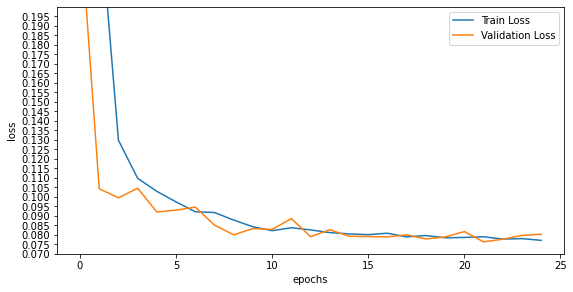

In [49]:
loss0 = pd.read_csv('../thesis/performance/RunsTMVICombinedTabOnly/history.csv')
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(loss0['train_loss'],label="Train Loss")
plt.plot(loss0['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.07,0.2)
plt.yticks(np.arange(0.07, 0.2, 0.005))
plt.legend()
#plt.savefig("./plots/uncertainty/LOSS_TMVICombinedTabularOnly.pdf")

## Performance

In [55]:

### performance
xtest = [standAgeTe, test_imgs_scaled]
y_pred = model1.predict(xtest,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)



2021-11-19 14:29:34.718416: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.


In [56]:
# logscore
logScore(test_labels,predictions)

-0.07530307112056055

In [57]:
# AUC
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.84, 95% CI: 0.81-0.87


## Modell 2 CNN with last layer MF-TM-VI ,  linear shift TMVi

### Training with "warmstart"

In [14]:
### Kein Bias Bei Linear Shift
M=50
theta_start = -2   
theta_stop = 2

vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] +
                              [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])                  

In [15]:
## Complex shift image
in_ = keras.Input(shape = (128,128,3), name = "inImg")

x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)                  
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
eta = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,    ###Linear
                      num_samples=1000,
                      size = 21200,
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x)
nn_im = keras.Model (inputs = in_, outputs = eta)
#nn_im.summary()

In [16]:
  ##add 
def linkProbab(X):
    added = X.layers[14].output
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = X.input, outputs = out, name='CNN-Warstart')
    return model1 
nn_image = linkProbab(nn_im)
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)

#### Train model

In [ ]:
results = nn_image.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 5,
                        verbose= True)    

In [43]:
#### save model weights only eta
#nn_im.save_weights("../thesis/models/warmstart/CNNLastLayerTMVI", save_format ="tf")
#### save model weights whole model
#nn_image.save_weights("../thesis/models/warmstart/CNNLastLayerTMVIWhole", save_format ="tf")

## MF-TM-VI Combined model
#### with previous warmstart training of image and tabular data

In [18]:
### image load eta modell
nn_im.compile(optimizer=Adam(lr=1e-5), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_im.load_weights("../thesis/models/warmstart/CNNLastLayerTMVI")
##linear shift
nn_tab1.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_tab1.load_weights("../thesis/models/CNN+tabMFVI_onlyTab")


In [19]:
# combine model
epochs = 18
batch_size = 256
opt = Adam(1e-3)
model = modelOn(nn_tab1,nn_im)
model.compile(optimizer=opt, loss=sample_bernoulli_nll, run_eagerly=False)   

#### Train model

In [ ]:
results = model.fit(x ={'inImg': train_imgs_scaled, 'inCov': standAge}, 
                        y = train_labels,
                        validation_data = ({'inImg': validation_imgs_scaled,'inCov': standAgeValid}, val_labels),
                        batch_size=batch_size,
                        epochs = epochs,  
                        verbose= True,
                       )    

In [93]:
# save results
#dat = pd.DataFrame({'train_loss': model.history.history['loss'], 
                       # 'val_loss': model.history.history['val_loss']})
#dat.to_csv('../thesis/RunsTMVICombinedBoth/history.csv', index=False)

#### save model weights beta
#nn_tab1.save_weights("models/warmstart/CombinedModelBeta", save_format ="tf")

#### save model weights whole
#nn_im.save_weights("models/warmstart/CombinedModelEta", save_format ="tf")

#### save model weights whole
#model.save_weights("models/warmstart/CombinedModelWhole", save_format ="tf")

#### Load weights

In [20]:
### recreate Model
model.compile(optimizer=opt, loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
### load the state of the old model
model.load_weights("../thesis/models/warmstart/CombinedModelWhole")

## load posterior slope
layer = nn_tab1.layers[1]
qw, w = layer.get_w_dist()

##load posterior sample direct
layerW = nn_tab1.layers[1]
wSample = layerW.samplew()


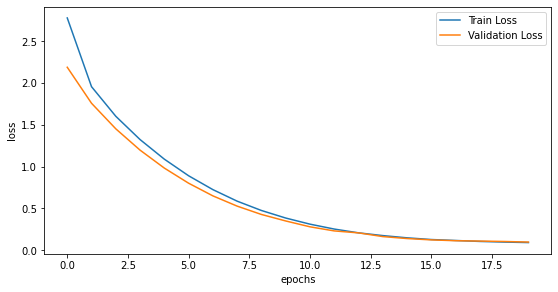

In [39]:
loss0 = pd.read_csv('../thesis/performance/RunsTMVICombinedBoth_Ad/history.csv')
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(loss0['train_loss'],label="Train Loss")
plt.plot(loss0['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
#plt.savefig("../thesis/plots/uncertainty/LOSS_TMVICombinedBoth.pdf")

## Performance

In [42]:
xtest = [standAgeTest,test_imgs_scaled, ]
y_pred = model.predict(xtest,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)


2021-11-21 15:05:59.094029: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.


In [43]:
# logscore
logScore(test_labels,predictions)

-0.07412091101982683

In [44]:
# AUC
meanPredsAuc= predictions.ravel()
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanPredsAuc, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

AUC=0.85, 95% CI: 0.82-0.88


## Example OOD 

### 1. OOD age (10) and image (random)

In [35]:
##random image
input_shape = (128, 128, 3)
random_img = np.random.random(input_shape)
ss=np.expand_dims(random_img, axis=0)

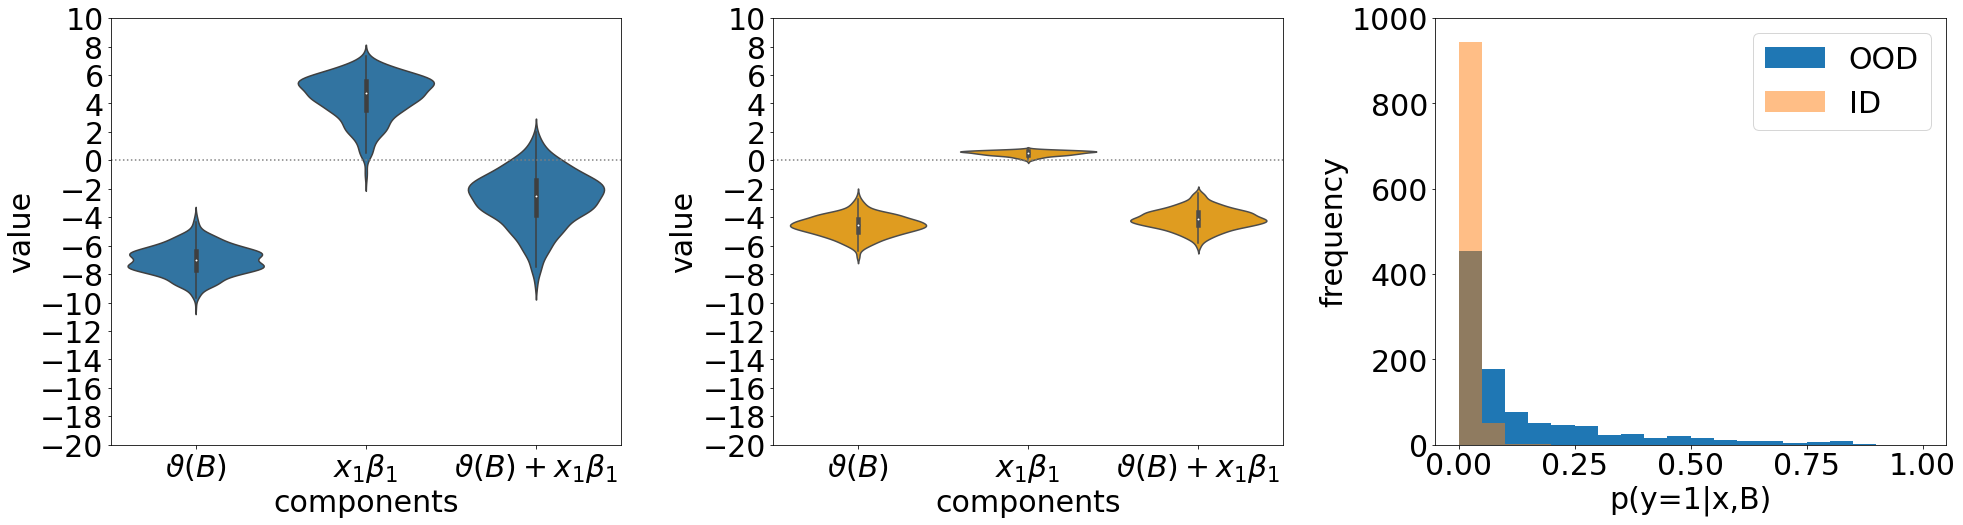

In [40]:
%reload_ext autoreload

age = [10]
agePostiveOOD = pd.DataFrame({'age': age}, columns=['age'])
plotOODExample(agePostiveOOD,ss,standAgeTest[10:11],test_imgs_scaled[10:11],model,nn_im,nn_tab1)

### 2. OOD age (-10) and image (random)

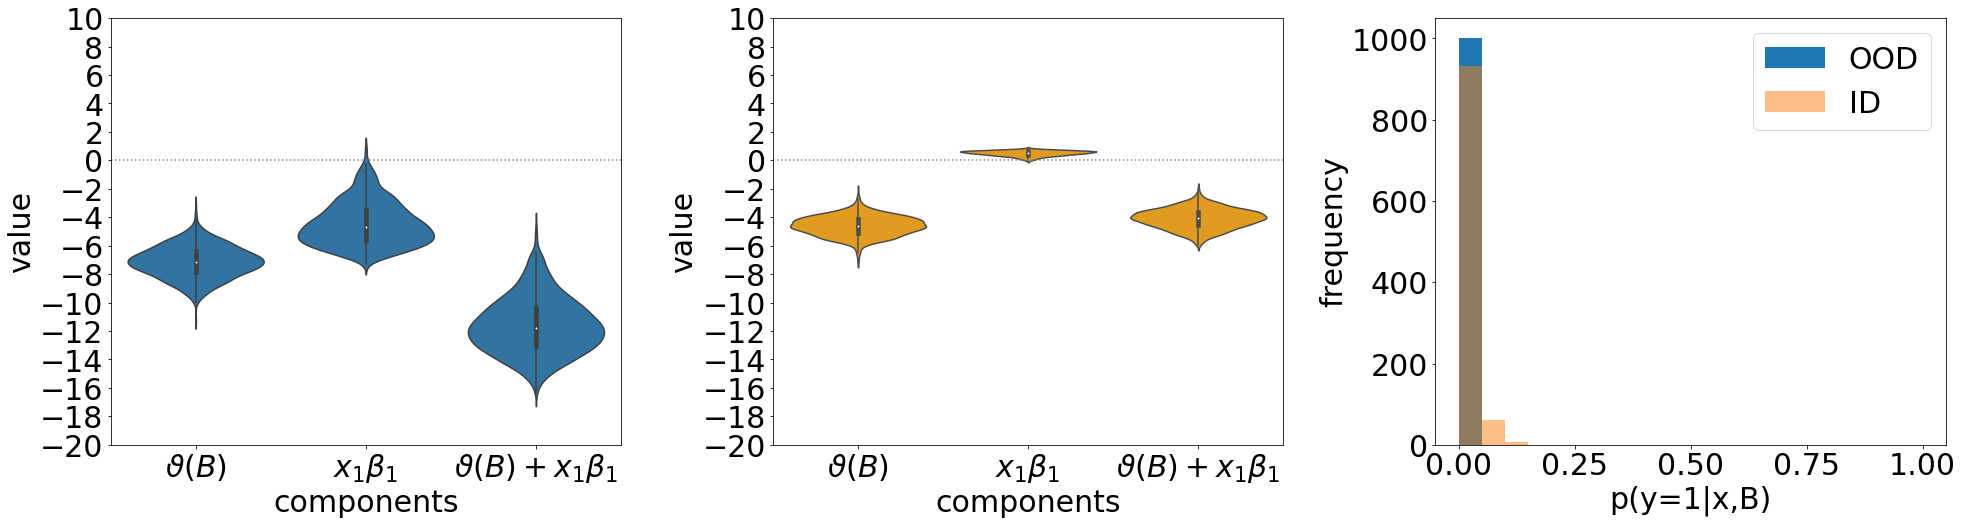

In [42]:
age = [-10]
agePostiveOOD = pd.DataFrame({'age': age}, columns=['age'])
plotOODExample(agePostiveOOD,ss,standAgeTest[10:11],test_imgs_scaled[10:11],model,nn_im,nn_tab1)

### 3. OOD Age (10) and ID Image

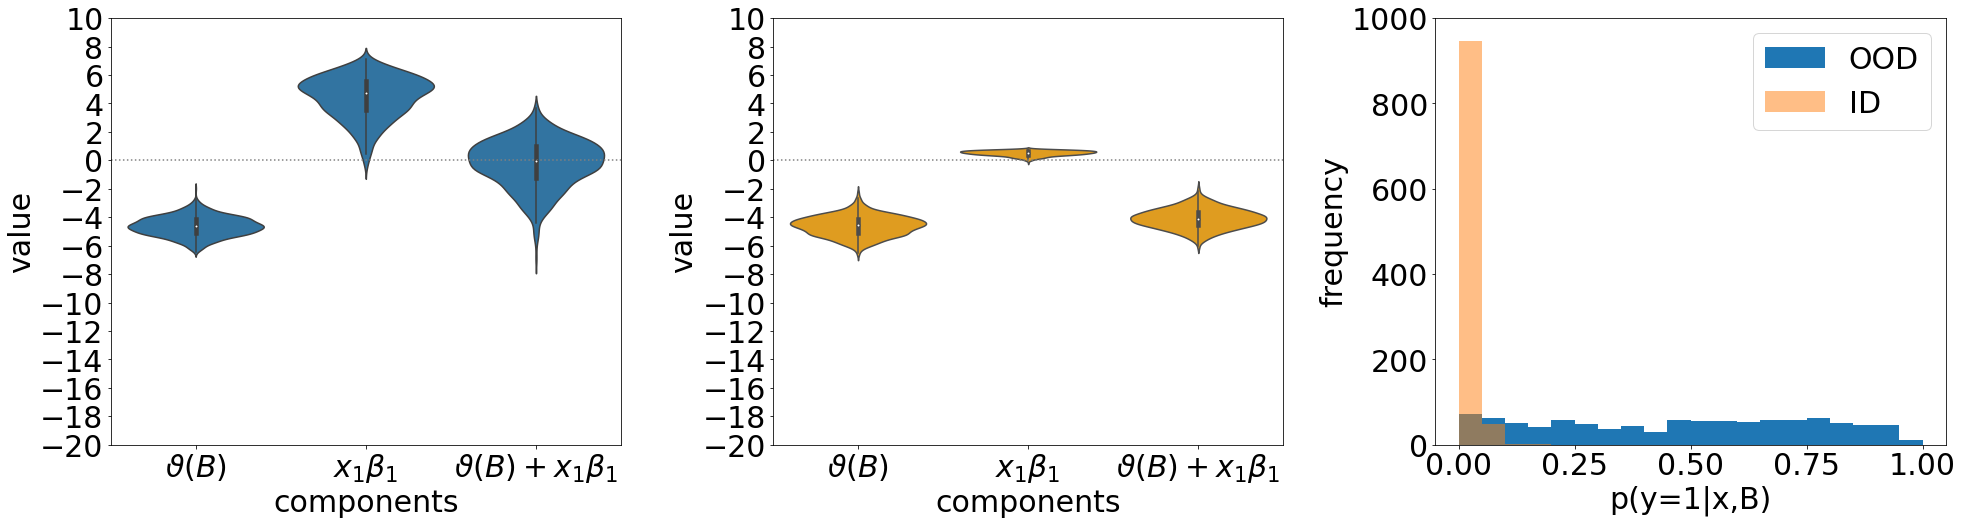

In [43]:
age = [10]
agePostiveOOD = pd.DataFrame({'age': age}, columns=['age'])
plotOODExample(agePostiveOOD,test_imgs_scaled[10:11],standAgeTest[10:11],test_imgs_scaled[10:11],model,nn_im,nn_tab1)

### 4. OOD Age(-10) and ID Image

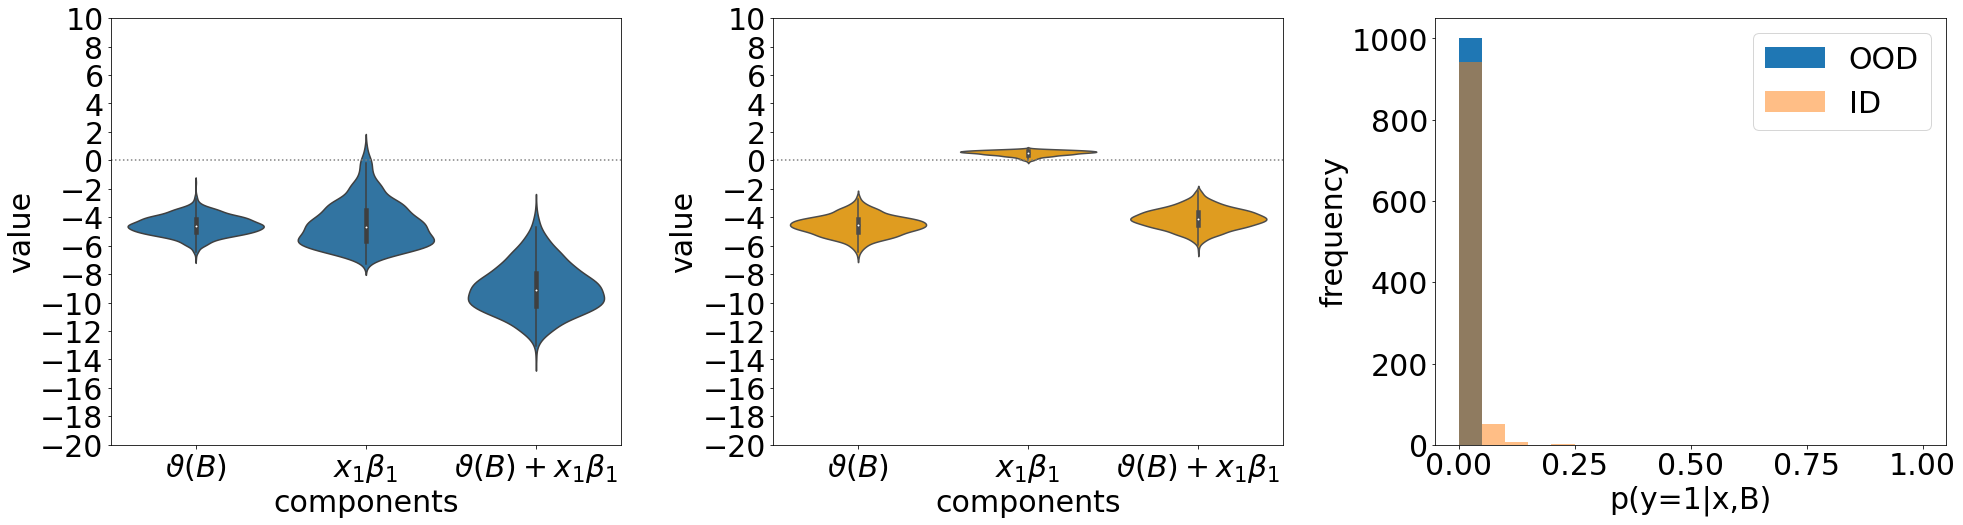

In [45]:
age = [-10]
agePostiveOOD = pd.DataFrame({'age': age}, columns=['age'])
plotOODExample(agePostiveOOD,test_imgs_scaled[10:11],standAgeTest[10:11],test_imgs_scaled[10:11],model,nn_im,nn_tab1)

### 5. ID age and OOD image (random)

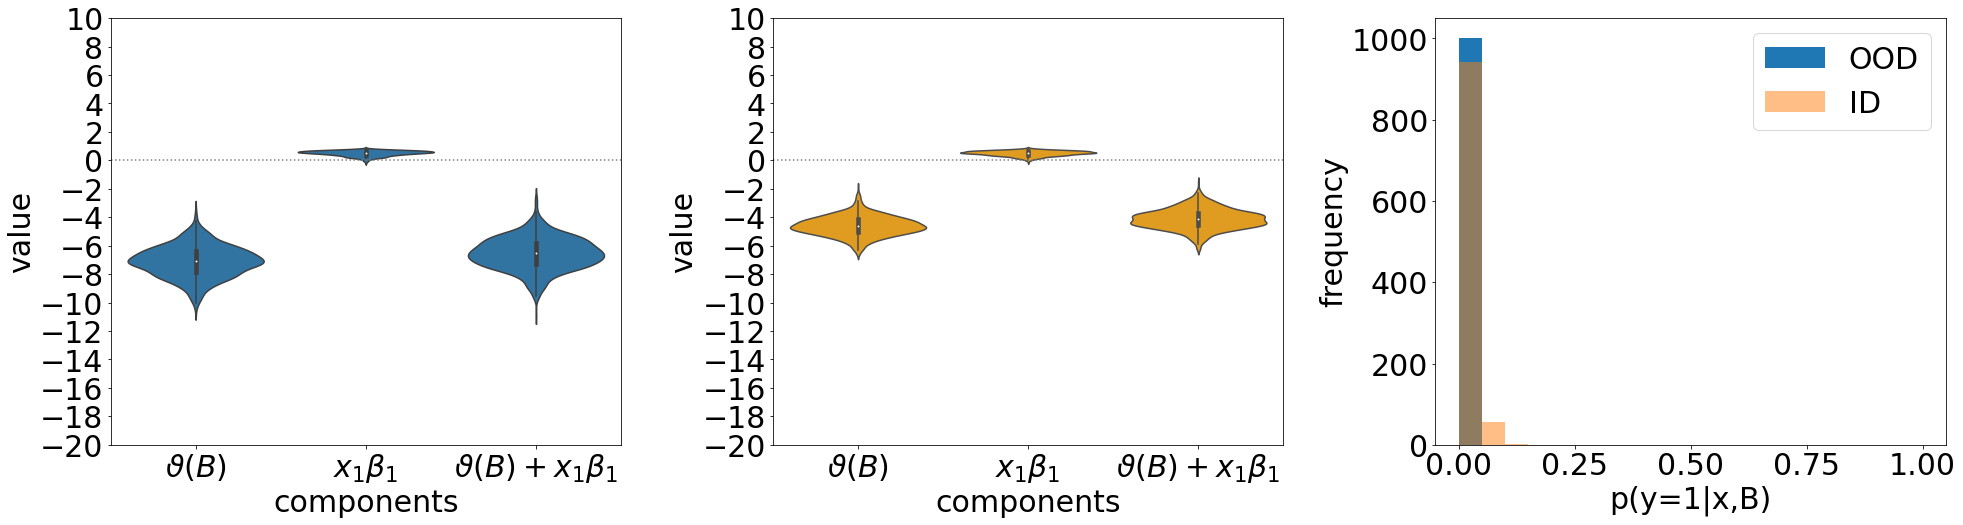

In [47]:
plotOODExample(standAgeTest[10:11],ss,standAgeTest[10:11],test_imgs_scaled[10:11],model,nn_im,nn_tab1)

## Logits models 

#### Load weights of eta (B)

In [122]:
##load eta (B)
nn_im.compile(optimizer=Adam(1e-5), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
### load the state of the old model
nn_im.load_weights("../thesis/models/warmstart/CombinedModelEta")

In [124]:
xtest = [test_imgs_scaled]
y_pred = nn_im.predict(xtest,batch_size =1)
samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)
y_predictions_2p5=np.quantile(samples,0.025,axis=1)
y_predictions_97p5=np.quantile(samples,0.975,axis=1)

#### Load weights of beta

In [125]:
##load liner shift
nn_tab1.compile(optimizer=Adam(1e-5), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
### load the state of the old model
nn_tab1.load_weights("../thesis/models/warmstart/CombinedModelBeta")

In [126]:
#predictions
xtestTab = [standAgeTest]
y_predTab = nn_tab1.predict(xtestTab,batch_size =1)

samplesTab = y_predTab.reshape(-1, 1000) ###every datapoint one sample
meanpredTab = samplesTab.mean(axis=1)  ###mean samples 
predictionsTab=meanpredTab.reshape(6626,1)
y_predictions_2p5Tab=np.quantile(samplesTab,0.025,axis=1)
y_predictions_97p5Tab=np.quantile(samplesTab,0.975,axis=1)

#### Combined model (before sigmoid)

In [128]:
xtestCom = {'inImg': test_imgs_scaled, 'inCov': standAgeTe}
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_output = intermediate_layer_model.predict(xtestCom,batch_size=1)

In [129]:
samplesComb = intermediate_output.reshape(-1, 1000) ###every datapoint one sample
meanpredComb = samplesComb.mean(axis=1)  ###mean samples 
predictionsComb=meanpredComb.reshape(6626,1)
y_predictions_2p5Comb=np.quantile(samplesComb,0.025,axis=1)
y_predictions_97p5Comb=np.quantile(samplesComb,0.975,axis=1)

#### Distribution outcome of parameter

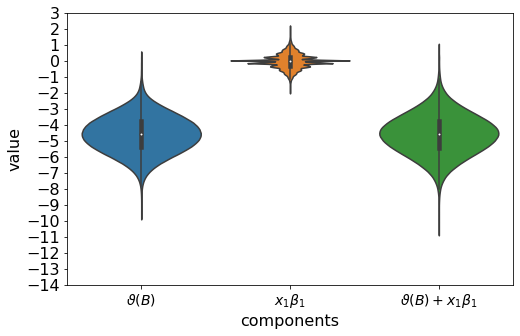

In [130]:
plt.figure(figsize=(8,5))
plt.rcParams.update(({'font.size': 16}))
dat2 = [samples,samplesTab,samplesComb]
sns.violinplot(data=dat2,scale='width')
plt.xticks([0, 1, 2], ['$\\vartheta(B)$', '$x_1 \\beta_1$', '$\\vartheta(B)+x_1 \\beta_1$'],fontsize=14)
plt.ylabel("value")
plt.xlabel("components")
plt.yticks(np.arange(-14, 4, 1))
#plt.savefig("./plots/uncertainty/uncertaintyRangeComponentsTestdata.pdf")
plt.show()

## Multiple data: Volcano plot with interquartile range 

### Tabular Linear Shift

#### OOD predictions

In [21]:
##OOD prediction 
oodTabNegative = np.arange(-10, -4, 0.1)
oodTabPositive = np.arange(4, 10, 0.1)
oodTab = [*oodTabNegative, *oodTabPositive]
y_predTabOOD = nn_tab1.predict(oodTab,batch_size =1)
samplesTabOOD = y_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
meanpredTabOOD = samplesTabOOD.mean(axis=1)  ###mean samples 
predictionsTabOOD=meanpredTabOOD.reshape(120,1)

y_predictions25TabOOD=np.quantile(samplesTabOOD,0.25,axis=1) ##IQR 
y_predictions75TabOOD=np.quantile(samplesTabOOD,0.75,axis=1) ##IQR
##dataframe
tabCenterOOD = [sublist[-1] for sublist in predictionsTabOOD]
tabLowOOD = [sublist[-1] for sublist in y_predictions25TabOOD.reshape(120,1)]
tabHighOOD = [sublist[-1] for sublist in y_predictions75TabOOD.reshape(120,1)]
##IQR range
widthOOD= [x1 - x2 for (x1, x2) in zip(tabHighOOD, tabLowOOD)]

#### ID predictions (120 test data)

In [22]:
###vorbereitung tabular only 120 from testdata
xtestTabSample = standAgeTe[120:240]
y_predTabSample = nn_tab1.predict(xtestTabSample,batch_size =1)

samplesTabSample = y_predTabSample.reshape(-1, 1000) ###every datapoint one sample
meanpredTabSample = samplesTabSample.mean(axis=1)  ###mean samples 
predictionsTabSample=meanpredTabSample.reshape(120,1)
y_predictions25Tab=np.quantile(samplesTabSample,0.25,axis=1)
y_predictions75Tab=np.quantile(samplesTabSample,0.75,axis=1)

tabCenterSample = [sublist[-1] for sublist in meanpredTabSample.reshape(120,1)]
tabLowSample = [sublist[-1] for sublist in y_predictions25Tab.reshape(120,1)]
tabHighSample = [sublist[-1] for sublist in y_predictions75Tab.reshape(120,1)]
widthSample= [x1 - x2 for (x1, x2) in zip(y_predictions75Tab, y_predictions25Tab)]

tabulardata = pd.DataFrame(
    {'width': widthSample,
     'center': tabCenterSample
    })

###Out of distribution
tabulardataOOD = pd.DataFrame(
    {'width': widthOOD,
     'center': tabCenterOOD
    })


### Image eta(B)

#### OOD predictions (random & augmentation)

In [23]:
#####OOD two times: random and augmented

#random
y_predTabOOD = nn_im.predict(oodRandom,batch_size =1)
samplesImgOOD = y_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOOD = samplesImgOOD.mean(axis=1)  ###mean samples 
predictionsImgOOD=meanpredImgOOD.reshape(17,1)
#IQR
y_predictions25ImgOOD=np.quantile(samplesImgOOD,0.25,axis=1)
y_predictions75ImgOOD=np.quantile(samplesImgOOD,0.75,axis=1)
##dataframe
ImgCenterOOD = [sublist[-1] for sublist in predictionsImgOOD]
ImgLowOOD = [sublist[-1] for sublist in y_predictions25ImgOOD.reshape(17,1)]
ImgHighOOD = [sublist[-1] for sublist in y_predictions75ImgOOD.reshape(17,1)]
#IQR range
ImgwidthOOD= [x1 - x2 for (x1, x2) in zip(ImgHighOOD, ImgLowOOD)]

#aug
y_predTabOODA = nn_im.predict(bright,batch_size =1)
samplesImgOODA = y_predTabOODA.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOODA = samplesImgOODA.mean(axis=1)  ###mean samples 
predictionsImgOODA=meanpredImgOODA.reshape(103,1)
y_predictions25ImgOODA=np.quantile(samplesImgOODA,0.25,axis=1)
y_predictions75ImgOODA=np.quantile(samplesImgOODA,0.75,axis=1)
##dataframe
ImgCenterOODA = [sublist[-1] for sublist in predictionsImgOODA]
ImgLowOODA = [sublist[-1] for sublist in y_predictions25ImgOODA.reshape(103,1)]
ImgHighOODA = [sublist[-1] for sublist in y_predictions75ImgOODA.reshape(103,1)]
ImgwidthOODA= [x1 - x2 for (x1, x2) in zip(ImgHighOODA, ImgLowOODA)]

#### ID predictions (120 testdata)

In [24]:
###vorbereitung image
###only 120
y_predSample = nn_im.predict(test_imgs_scaled[120:240],batch_size =1)


samplesSample = y_predSample.reshape(-1, 1000) ###every datapoint one sample
meanpredSample = samplesSample.mean(axis=1)  ###mean samples 
predictionsSample=meanpredSample.reshape(120,1)
#IQR
y_predictions25ImgSample=np.quantile(samplesSample,0.25,axis=1)
y_predictions75ImgSample=np.quantile(samplesSample,0.75,axis=1)

ImgCenterSample = [sublist[-1] for sublist in meanpredSample.reshape(120,1)]
ImgLowSample = [sublist[-1] for sublist in y_predictions25ImgSample.reshape(120,1)]
ImgHighSample = [sublist[-1] for sublist in y_predictions75ImgSample.reshape(120,1)]
#IQR range
ImgwidthSample= [x1 - x2 for (x1, x2) in zip(ImgHighSample, ImgLowSample)]


imagedata = pd.DataFrame(
    {'width': ImgwidthSample,
     'center': ImgCenterSample
    })

###Out of distribution

imagadataOOD = pd.DataFrame(
    {'width': ImgwidthOOD,
     'center': ImgCenterOOD
    })
###Out of distribution AUG

imagadataOODA = pd.DataFrame(
    {'width': ImgwidthOODA,
     'center': ImgCenterOODA
    })


### Combined model CIb LSx
#### 1. OOD both 

In [25]:
oodTabR = oodTab[0:17]

oodTabArr=np.asarray(oodTabR)
#Image random
xtestComOOD = [oodTabArr,oodRandom]
intermediate_layer_modelOOD = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_outputOOD = intermediate_layer_modelOOD.predict(xtestComOOD,batch_size=1)

samplesComOOD = intermediate_outputOOD.reshape(-1, 1000) ###every datapoint one sample
meanpredComOOD = samplesComOOD.mean(axis=1)  ###mean samples 
predictionsComOOD=meanpredComOOD.reshape(17,1)
#IQR
y_predictions25Comb=np.quantile(samplesComOOD,0.25,axis=1)
y_predictions75Comb=np.quantile(samplesComOOD,0.75,axis=1)

##dataframe
ComCenterOOD = [sublist[-1] for sublist in samplesComOOD]
ComLowOOD = [sublist[-1] for sublist in y_predictions25Comb.reshape(17,1)]
ComHighOOD = [sublist[-1] for sublist in y_predictions75Comb.reshape(17,1)]
#IQR range
ComwidthOOD= [x1 - x2 for (x1, x2) in zip(ComHighOOD, ComLowOOD)]

##image augmented
oodTabA = np.asarray(oodTab[17:120])
xtestComOODA = [oodTabA,bright]
intermediate_layer_modelOODA = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_outputOODA = intermediate_layer_modelOODA.predict(xtestComOODA,batch_size=1)

samplesComOODA = intermediate_outputOODA.reshape(-1, 1000) ###every datapoint one sample
meanpredComOODA = samplesComOODA.mean(axis=1)  ###mean samples 
predictionsComOODA=meanpredComOODA.reshape(103,1)
y_predictions25CombA=np.quantile(samplesComOODA,0.25,axis=1)
y_predictions75CombA=np.quantile(samplesComOODA,0.75,axis=1)


##dataframe
ComCenterOODA = [sublist[-1] for sublist in samplesComOODA]
ComLowOODA = [sublist[-1] for sublist in y_predictions25CombA.reshape(103,1)]
ComHighOODA = [sublist[-1] for sublist in y_predictions75CombA.reshape(103,1)]
ComwidthOODA= [x1 - x2 for (x1, x2) in zip(ComHighOODA, ComLowOODA)]


#### 2. OOD unknown image (random/aug.), but known age

In [26]:
oodTabR2 = standAgeTest[0:17]
#random image
xtestComOOD2 = [oodTabR2,oodRandom]
intermediate_layer_modelOOD2 = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_outputOOD2 = intermediate_layer_modelOOD2.predict(xtestComOOD2,batch_size=1)
samplesComOOD2 = intermediate_outputOOD2.reshape(-1, 1000) ###every datapoint one sample
meanpredComOOD2 = samplesComOOD2.mean(axis=1)  ###mean samples 
predictionsComOOD2=meanpredComOOD2.reshape(17,1)
#IQR
y_predictions25Comb2=np.quantile(samplesComOOD2,0.25,axis=1)
y_predictions75Comb2=np.quantile(samplesComOOD2,0.75,axis=1)

##dataframe
ComCenterOOD2 = [sublist[-1] for sublist in samplesComOOD2]
ComLowOOD2 = [sublist[-1] for sublist in y_predictions25Comb2.reshape(17,1)]
ComHighOOD2 = [sublist[-1] for sublist in y_predictions75Comb2.reshape(17,1)]
#IQR range
ComwidthOOD2= [x1 - x2 for (x1, x2) in zip(ComHighOOD2, ComLowOOD2)]


#image augmentation
oodTabA2 = standAgeTest[17:120]
xtestComOODA2 = [oodTabA2,bright]
intermediate_layer_modelOODA2 = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_outputOODA2 = intermediate_layer_modelOODA2.predict(xtestComOODA2,batch_size=1)
samplesComOODA2 = intermediate_outputOODA2.reshape(-1, 1000) ###every datapoint one sample
meanpredComOODA2 = samplesComOODA2.mean(axis=1)  ###mean samples 
predictionsComOODA2=meanpredComOODA2.reshape(103,1)
#IQR
y_predictions25CombA2=np.quantile(samplesComOODA2,0.25,axis=1)
y_predictions75CombA2=np.quantile(samplesComOODA2,0.75,axis=1)


##dataframe
ComCenterOODA2 = [sublist[-1] for sublist in samplesComOODA2]
ComLowOODA2 = [sublist[-1] for sublist in y_predictions25CombA2.reshape(103,1)]
ComHighOODA2 = [sublist[-1] for sublist in y_predictions75CombA2.reshape(103,1)]
#IQR range
ComwidthOODA2= [x1 - x2 for (x1, x2) in zip(ComHighOODA2, ComLowOODA2)]

#### 3. Known image, but OOD age

In [27]:
oodTabR3 = oodTab[0:120]
oodTabArr3=np.asarray(oodTabR3)
xtestComOOD3 = [oodTabArr3,test_imgs_scaled[120:240]]
intermediate_layer_modelOOD3 = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_outputOOD3 = intermediate_layer_modelOOD3.predict(xtestComOOD3,batch_size=1)
samplesComOOD3 = intermediate_outputOOD3.reshape(-1, 1000) ###every datapoint one sample
meanpredComOOD3 = samplesComOOD3.mean(axis=1)  ###mean samples 
predictionsComOOD3=meanpredComOOD3.reshape(120,1)
#IQR
y_predictions25Comb3=np.quantile(samplesComOOD3,0.25,axis=1)
y_predictions75Comb3=np.quantile(samplesComOOD3,0.75,axis=1)

##dataframe
ComCenterOOD3 = [sublist[-1] for sublist in samplesComOOD3]
ComLowOOD3 = [sublist[-1] for sublist in y_predictions25Comb3.reshape(120,1)]
ComHighOOD3 = [sublist[-1] for sublist in y_predictions75Comb3.reshape(120,1)]
#IQR range
ComwidthOOD3= [x1 - x2 for (x1, x2) in zip(ComHighOOD3, ComLowOOD3)]

#### 4. image and age known

In [28]:
###only 120
xtestComb = [xtestTabSample,test_imgs_scaled[120:240]]
intermediate_layer_modelOOD = Model(inputs=model.input, outputs=model.layers[17].output)
intermediate_outputOOD = intermediate_layer_modelOOD.predict(xtestComb,batch_size=1)
CombSample = intermediate_outputOOD.reshape(-1, 1000) ###every datapoint one sample
meanpredSampleComb = samplesSample.mean(axis=1)  ###mean samples 
predictionsSampleComb=meanpredSample.reshape(120,1)
#IQR
y_predictions25ImgSample=np.quantile(CombSample,0.25,axis=1)
y_predictions75ImgSample=np.quantile(CombSample,0.75,axis=1)

CombCenterSample = [sublist[-1] for sublist in meanpredSampleComb.reshape(120,1)]
CombLowSample = [sublist[-1] for sublist in y_predictions25ImgSample.reshape(120,1)]
CombHighSample = [sublist[-1] for sublist in y_predictions75ImgSample.reshape(120,1)]
#IQR range
CombwidthSample= [x1 - x2 for (x1, x2) in zip(CombHighSample, CombLowSample)]


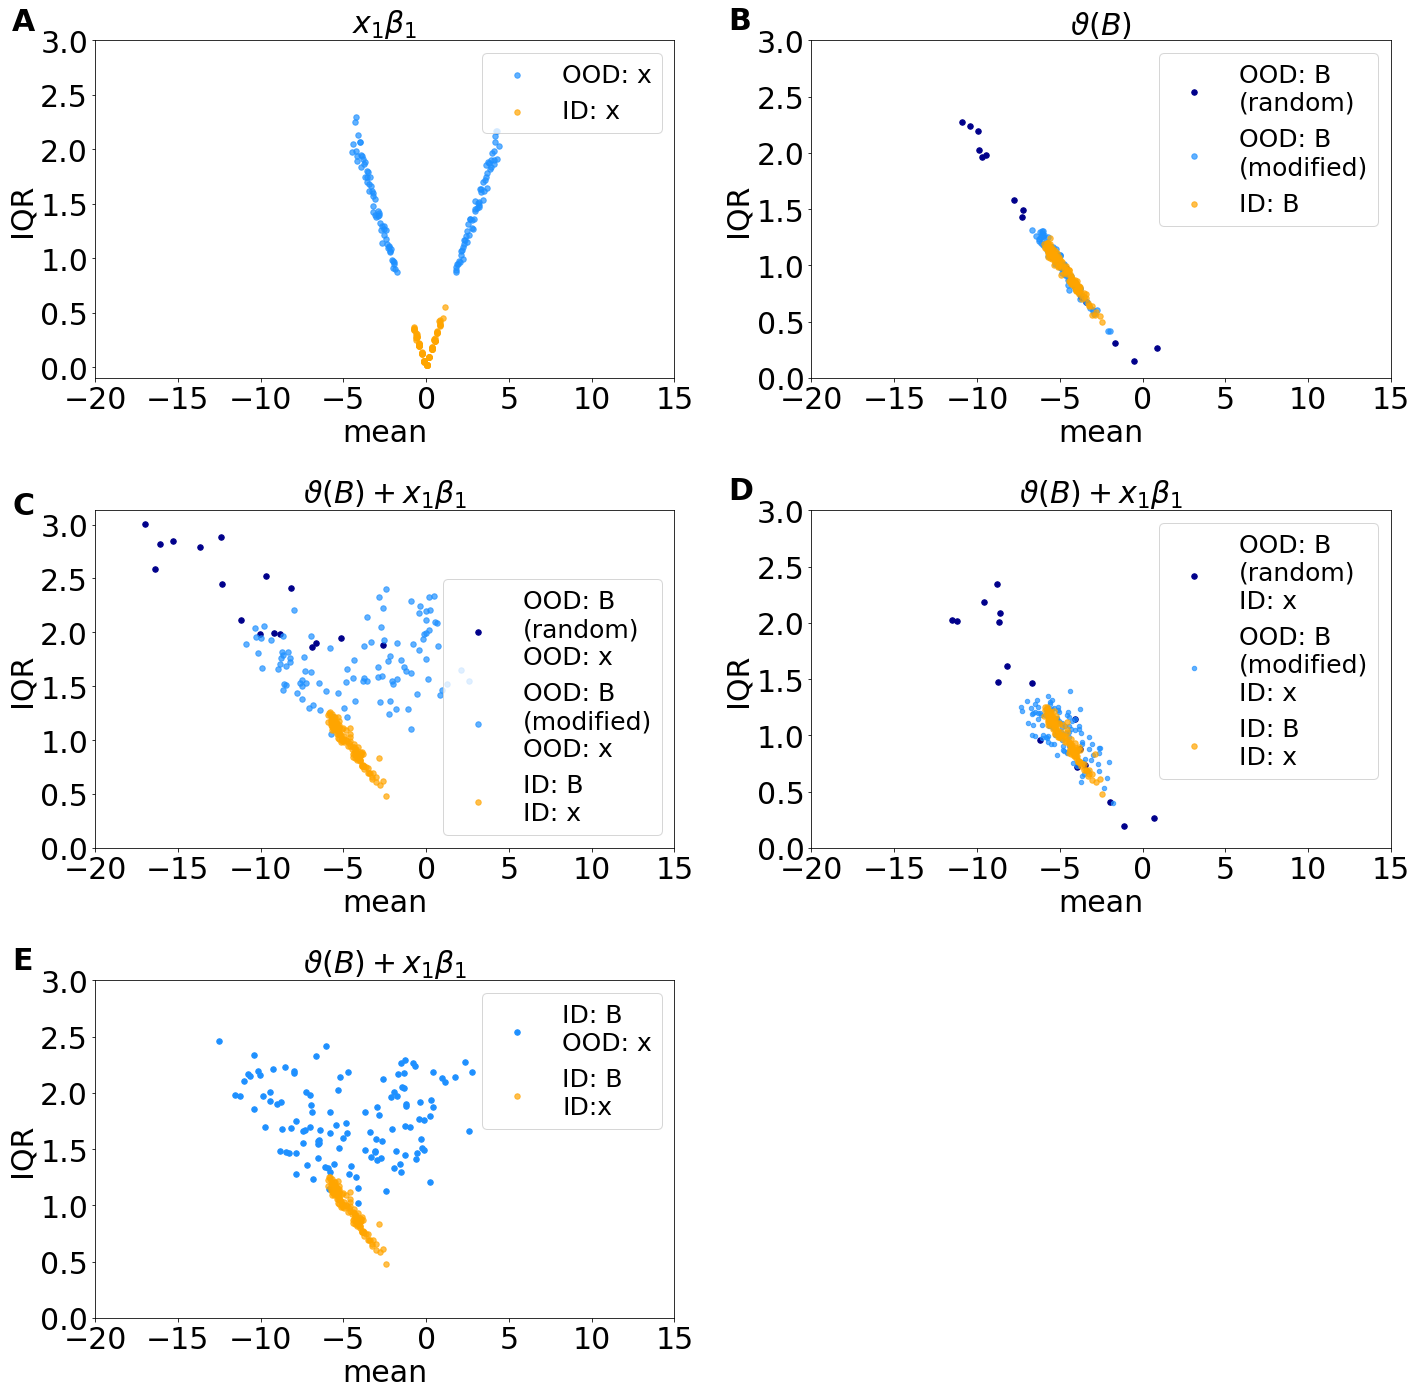

In [42]:
#ID combined
combineddata = pd.DataFrame({'width': CombwidthSample,'center': CombCenterSample})
#OOD combined random image
combineddataOOD = pd.DataFrame({'width': ComwidthOOD,'center': ComCenterOOD})
#OOD combined aug. image
combineddataOODA = pd.DataFrame({'width': ComwidthOODA, 'center': ComCenterOODA})
#OOD image only (aug.)
combineddataOODA2 = pd.DataFrame({'width': ComwidthOODA2,'center': ComCenterOODA2})
#OOD iamge only (random)
combineddataOOD2 = pd.DataFrame({'width': ComwidthOOD2,'center': ComCenterOOD2})
#OOD age only
combineddataOOD3 = pd.DataFrame({'width': ComwidthOOD3,'center': ComCenterOOD3})

fig= plt.figure(figsize=(30,20),constrained_layout=True)
plt.rcParams.update(({'font.size': 30}))

# Tabular data only
plt.subplot(331)
plt.scatter(tabulardataOOD["center"],tabulardataOOD["width"],alpha=0.7,s=30,label="OOD: x",color="dodgerblue")
plt.scatter(tabulardata["center"],tabulardata["width"],label="ID: x",alpha=0.7,s=30,color="orange")
plt.text(-25, 3.1,"A", size=30, weight='bold')
plt.ylabel("IQR")
plt.legend(loc="upper right",fontsize=25)
plt.xlabel("mean")
plt.title("$x_1 \\beta_1$",fontsize=30)
plt.yticks(np.arange(0., 3.5, step=0.5))
plt.xticks(np.arange(-20., 20, step=5))

# Image data only
plt.subplot(332)
plt.scatter(imagadataOOD["center"],imagadataOOD["width"],label="OOD: B\n(random)",s=30,c="darkblue")
plt.scatter(imagadataOODA["center"],imagadataOODA["width"],label="OOD: B\n(modified)",alpha=0.7,s=30,c="dodgerblue")
plt.scatter(imagedata["center"],imagedata["width"],label="ID: B",alpha=0.7,s=30,color="orange")
plt.text(-25, 3.1,"B", size=30, weight='bold')
plt.ylabel("IQR")
plt.legend(loc= "upper right",fontsize=25)
plt.xlabel("mean")
plt.title("$\\vartheta(B)$",fontsize=30)
plt.yticks(np.arange(0., 3.5, step=0.5))
plt.xticks(np.arange(-20., 20, step=5))

# Image and tabular OOD
plt.subplot(334)
plt.scatter(combineddataOOD["center"],combineddataOOD["width"],label="OOD: B\n(random)\nOOD: x",s=30,color="darkblue")
plt.scatter(combineddataOODA["center"],combineddataOODA["width"],label="OOD: B\n(modified)\nOOD: x",alpha=0.7,s=30,color="dodgerblue")
plt.scatter(combineddata["center"],combineddata["width"],label="ID: B\nID: x",alpha=0.7,s=30,color="orange")
plt.text(-25, 3.1,"C", size=30, weight='bold')
plt.ylabel("IQR")
plt.title("$\\vartheta(B)+x_1 \\beta_1$",fontsize=30)
plt.xlabel("mean")
plt.yticks(np.arange(0., 3.5, step=0.5))
plt.xticks(np.arange(-20., 20, step=5))
plt.legend(loc= "lower right",fontsize=25)

#Image OOD, age ID
plt.subplot(335)
plt.scatter(combineddataOOD2["center"],combineddataOOD2["width"],label="OOD: B\n(random)\nID: x",s=30,color="darkblue")
plt.scatter(combineddataOODA2["center"],combineddataOODA2["width"],label="OOD: B\n(modified)\nID: x",alpha=0.7,s=20,color="dodgerblue")
plt.scatter(combineddata["center"],combineddata["width"],label="ID: B\nID: x",alpha=0.7,s=30,color="orange")
plt.text(-25, 3.1,"D", size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean")
plt.title("$\\vartheta(B)+x_1 \\beta_1$",fontsize=30)
plt.yticks(np.arange(0., 3.5, step=0.5))
plt.xticks(np.arange(-20., 20, step=5))
plt.legend(loc= "upper right",fontsize=25)

#Image ID, age OOD
plt.subplot(337)
plt.scatter(combineddataOOD3["center"],combineddataOOD3["width"],label="ID: B\nOOD: x",s=30,color="dodgerblue")
plt.scatter(combineddata["center"],combineddata["width"],label="ID: B\nID:x",alpha=0.7,s=30,color="orange")
plt.text(-25, 3.1,"E", size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean")
plt.title("$\\vartheta(B)+x_1 \\beta_1$",fontsize=30)
plt.yticks(np.arange(0., 3.5, step=0.5))
plt.xticks(np.arange(-20., 20, step=5))
plt.legend(loc= "upper right",fontsize=25)
fig.tight_layout(pad=1)
#plt.savefig('../thesis/plots/uncertainty/vulcanoScatter.pdf')

In [15]:
%reload_ext version_information
%version_information tensorflow,numpy, pandas, matplotlib

Software versions
Python 3.9.7 64bit [GCC 7.5.0]
IPython 7.27.0
OS Linux 5.8.0 63 generic x86_64 with glibc2.32
tensorflow 2.4.1
numpy 1.21.2
pandas 1.3.3
matplotlib 3.4.3
Wed Nov 24 11:48:26 2021 CET